In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import shutil
import time
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Path dataset
train_csv = "/kaggle/input/butterfly-image-classification/Training_set.csv"
train_folder = "/kaggle/input/butterfly-image-classification/train/"

test_csv = "/kaggle/input/butterfly-image-classification/Testing_set.csv"
test_folder = "/kaggle/input/butterfly-image-classification/test/"

## Result path
result_path = f"/kaggle/working/run/"
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.h5")
loss_image_path = os.path.join(result_path, 'validation loss.png')
acc_image_path = os.path.join(result_path, 'validation accuracy.png')
confusion_image_path = os.path.join(result_path, 'confusion matrix.png')

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

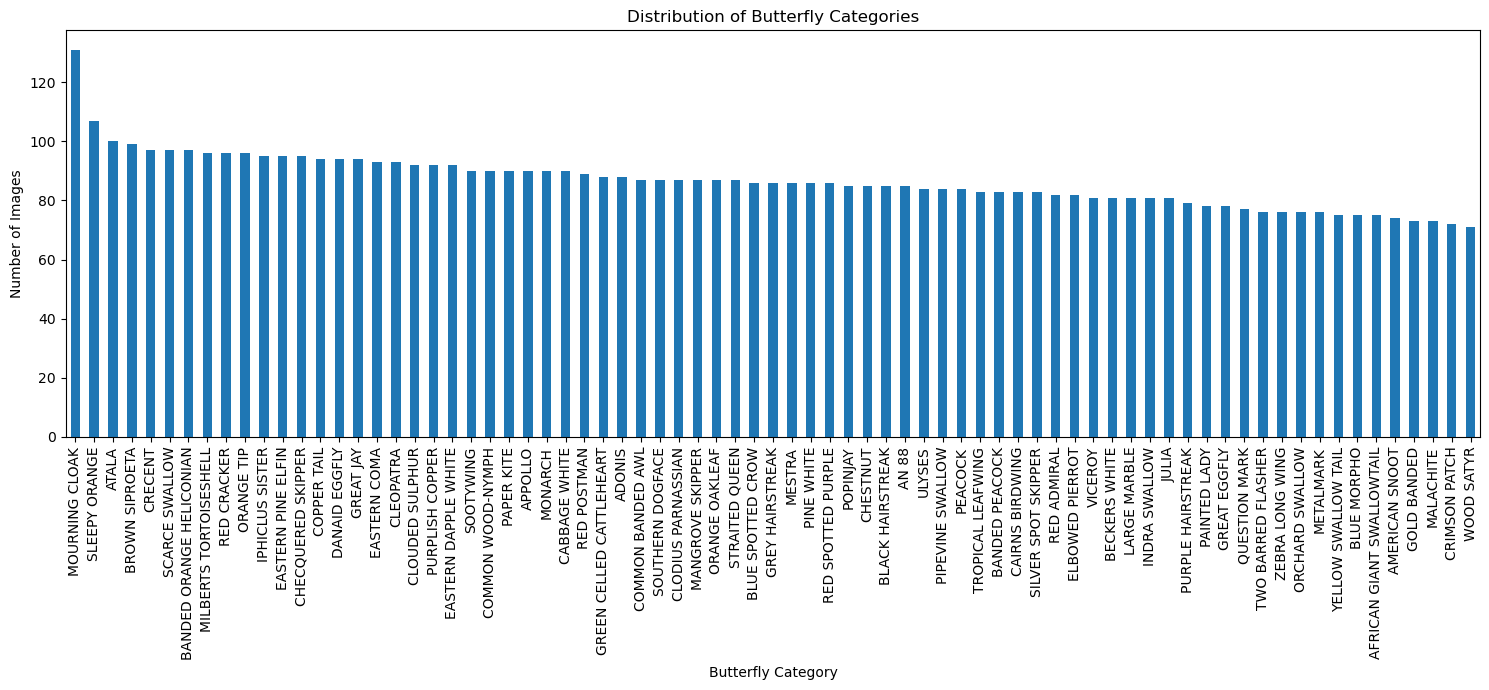

In [4]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
## Hyperparameter
image_size = (150, 150)
batch_size = 32
epochs = 100
learning_rate = 0.0001


class_name = list(set(train_df['label']))
print(class_name)

['RED CRACKER', 'EASTERN COMA', 'GREAT JAY', 'ATALA', 'PURPLISH COPPER', 'ORCHARD SWALLOW', 'EASTERN DAPPLE WHITE', 'AFRICAN GIANT SWALLOWTAIL', 'SOOTYWING', 'COMMON WOOD-NYMPH', 'ZEBRA LONG WING', 'YELLOW SWALLOW TAIL', 'GOLD BANDED', 'MOURNING CLOAK', 'GREY HAIRSTREAK', 'RED POSTMAN', 'RED ADMIRAL', 'PAPER KITE', 'GREEN CELLED CATTLEHEART', 'PEACOCK', 'MANGROVE SKIPPER', 'ADONIS', 'CHECQUERED SKIPPER', 'LARGE MARBLE', 'VICEROY', 'POPINJAY', 'MONARCH', 'PINE WHITE', 'CRIMSON PATCH', 'SCARCE SWALLOW', 'AN 88', 'SLEEPY ORANGE', 'CLODIUS PARNASSIAN', 'AMERICAN SNOOT', 'SOUTHERN DOGFACE', 'QUESTION MARK', 'BANDED PEACOCK', 'ORANGE OAKLEAF', 'SILVER SPOT SKIPPER', 'MILBERTS TORTOISESHELL', 'PIPEVINE SWALLOW', 'CLEOPATRA', 'JULIA', 'DANAID EGGFLY', 'BLACK HAIRSTREAK', 'BLUE SPOTTED CROW', 'CAIRNS BIRDWING', 'INDRA SWALLOW', 'METALMARK', 'ELBOWED PIERROT', 'IPHICLUS SISTER', 'CRECENT', 'GREAT EGGFLY', 'BANDED ORANGE HELICONIAN', 'CHESTNUT', 'RED SPOTTED PURPLE', 'BROWN SIPROETA', 'BLUE MORPH

In [6]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [01:38<00:00, 66.22it/s]


In [7]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

6499
6499


In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [9]:
del features
del labels

In [10]:
# Membuat model MobileNet
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)             

In [11]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Hitung waktu training
start_time = time.time()

# Latih model dengan menggunakan model checkpoint
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    callbacks=[model_checkpoint, early_stopping],
    batch_size = batch_size,
)

# Hitung waktu training
end_time = time.time()

Epoch 1/100
143/143 [==============================] - 36s 57ms/step - loss: 6.7942 - accuracy: 0.4865 - val_loss: 6.4308 - val_accuracy: 0.4985
Epoch 2/100
143/143 [==============================] - 6s 42ms/step - loss: 4.1382 - accuracy: 0.9354 - val_loss: 5.4098 - val_accuracy: 0.5897
Epoch 3/100
143/143 [==============================] - 6s 41ms/step - loss: 3.3563 - accuracy: 0.9866 - val_loss: 4.5175 - val_accuracy: 0.6421
Epoch 4/100
143/143 [==============================] - 6s 41ms/step - loss: 2.8083 - accuracy: 0.9919 - val_loss: 3.6624 - val_accuracy: 0.7200
Epoch 5/100
143/143 [==============================] - 6s 41ms/step - loss: 2.3327 - accuracy: 0.9956 - val_loss: 3.0275 - val_accuracy: 0.7579
Epoch 6/100
143/143 [==============================] - 6s 41ms/step - loss: 1.9624 - accuracy: 0.9934 - val_loss: 2.7628 - val_accuracy: 0.7549
Epoch 7/100
143/143 [==============================] - 6s 42ms/step - loss: 1.6185 - accuracy: 0.9993 - val_loss: 2.3413 - val_accuracy

In [12]:
print("Training Time", end_time - start_time)

Training Time 298.7563011646271


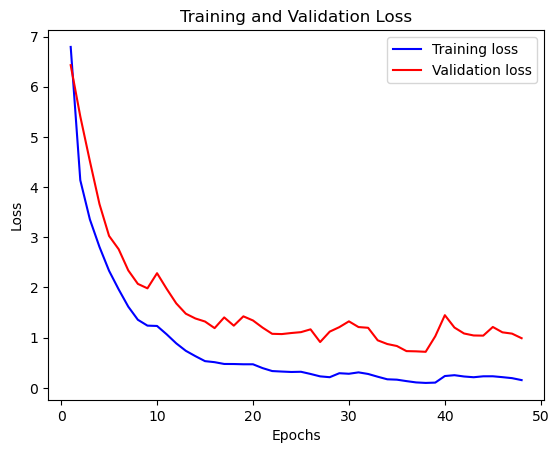

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(loss_image_path)
plt.show()

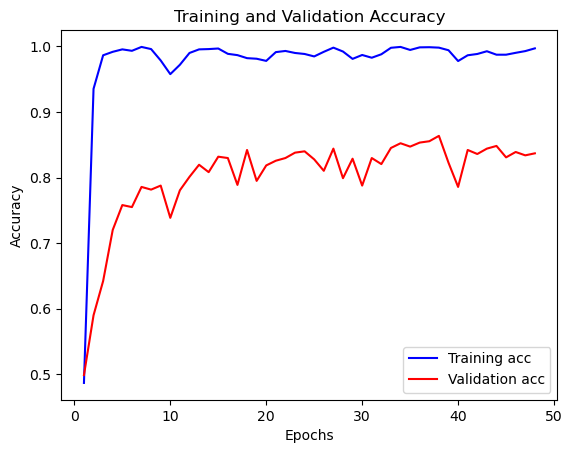

In [14]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(acc_image_path)
plt.show()

In [15]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

31/31 [==============================] - 1s 15ms/step
Classification Report:
                            precision    recall  f1-score   support

              RED CRACKER     1.0000    0.8750    0.9333        16
             EASTERN COMA     0.5455    0.4615    0.5000        13
                GREAT JAY     1.0000    0.8947    0.9444        19
                    ATALA     1.0000    1.0000    1.0000        19
          PURPLISH COPPER     0.7778    0.7778    0.7778        18
          ORCHARD SWALLOW     1.0000    0.8421    0.9143        19
     EASTERN DAPPLE WHITE     0.7619    0.8421    0.8000        19
AFRICAN GIANT SWALLOWTAIL     1.0000    1.0000    1.0000         8
                SOOTYWING     0.9091    0.7692    0.8333        13
        COMMON WOOD-NYMPH     1.0000    0.8889    0.9412         9
          ZEBRA LONG WING     1.0000    1.0000    1.0000        10
      YELLOW SWALLOW TAIL     0.9286    0.8667    0.8966        15
              GOLD BANDED     0.7778    1.0000    